Measure MSE - Iris

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import os
import numpy as np
import pandas as pd
import logging
from copy import deepcopy
from typing import List, Tuple, Dict, Callable
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import euclidean
from itertools import permutations, combinations
from joblib import load
import importlib

import tensorflow as tf

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import Pipeline

import VAE_DBS

# from VAE_DBS.models import dice_gradients
from VAE_DBS.models.dice_gradients import DiceCounterfactual
from VAE_DBS.utils.utils import *
from VAE_DBS.data.load_data import *
from VAE_DBS.models.DiCE.dice_ml.utils.helpers import DataTransfomer
import random
import VAE_DBS.visualization.create_map_embedding as create_map_embedding
import VAE_DBS.visualization.create_map.create_map_UMAP_test_no_intermediate as create_map_UMAP_test_no_intermediate
# import ssnp_main.code.ssnp as ssnp
import VAE_DBS.models.transformers.ssnp

import skdim
from sklearn.decomposition import PCA
from scipy.stats import entropy

%load_ext autoreload
%autoreload 2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


c:\Users\imke.bloemen\AppData\Local\anaconda3\envs\jan-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.values.ravel())

In [55]:
dataset = pd.DataFrame(data=X, columns=iris.data.feature_names)
dataset['target'] = y
outcome_name = 'target'
target = dataset[outcome_name]
features = dataset.drop(columns=[outcome_name])
selector = VarianceThreshold(threshold=0.0)
selector.fit(features)
features_selected = features[features.columns[selector.get_support(indices=True)]]
dataset = features_selected
dataset[outcome_name] = target

y, X = dataset[outcome_name].values, dataset.drop(columns=[outcome_name]).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=dataset.columns[:-1])
X_train['target'] = y_train
X_test = scaler.transform(X_test)

X_train.to_csv('../../../data/raw/iris.csv', index=False)

In [56]:
X_train

,sepal length,sepal width,petal length,petal width,target
0,0.027778,0.375000,0.051724,0.041667,0
1,0.166667,0.208333,0.586207,0.666667,2
2,0.694444,0.333333,0.637931,0.541667,1
3,0.166667,0.458333,0.068966,0.000000,0
4,0.333333,0.208333,0.500000,0.500000,1
...,...,...,...,...,...
115,0.166667,0.458333,0.068966,0.000000,0
116,0.111111,0.500000,0.034483,0.041667,0
117,0.333333,0.916667,0.051724,0.041667,0
118,0.722222,0.458333,0.655172,0.583333,1


None
True
input dim 4
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.8017 - val_loss: 0.7715
Epoch 2/50
1/1 [==============================] - 0s 224ms/step - loss: 0.7653 - val_loss: 0.7489
Epoch 3/50
1/1 [==============================] - 0s 243ms/step - loss: 0.7475 - val_loss: 0.7319
Epoch 4/50
1/1 [==============================] - 0s 194ms/step - loss: 0.7295 - val_loss: 0.7147
Epoch 5/50
1/1 [==============================] - 0s 228ms/step - loss: 0.7095 - val_loss: 0.6936
Epoch 6/50
1/1 [==============================] - 0s 211ms/step - loss: 0.6891 - val_loss: 0.6709
Epoch 7/50
1/1 [==============================] - 0s 195ms/step - loss: 0.6697 - val_loss: 0.6582
Epoch 8/50
1/1 [==============================] - 0s 161ms/step - loss: 0.6529 - val_loss: 0.6392
Epoch 9/50
1/1 [==============================] - 0s 189ms/step - loss: 0.6360 - val_loss: 0.6192
Epoch 10/50
1/1 [==============================] - 0s 189ms/step - loss: 0.6168 - val_loss: 0.6014


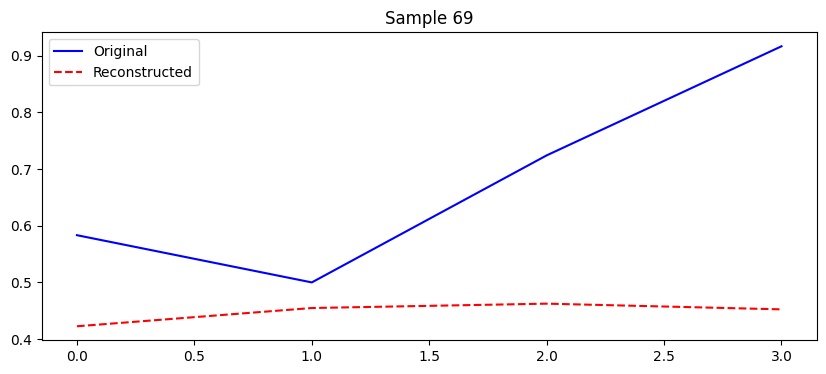

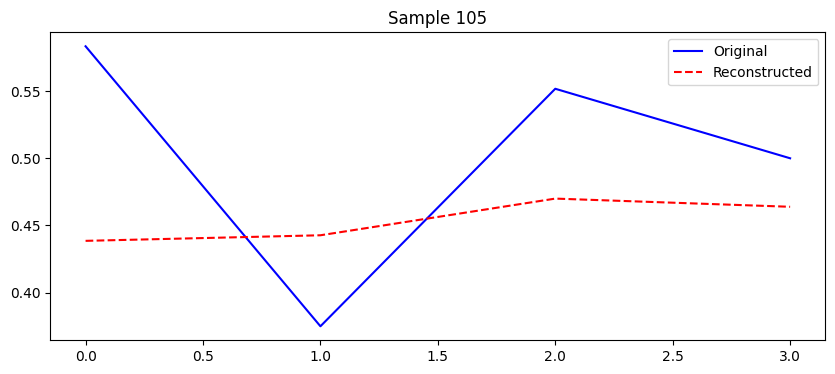

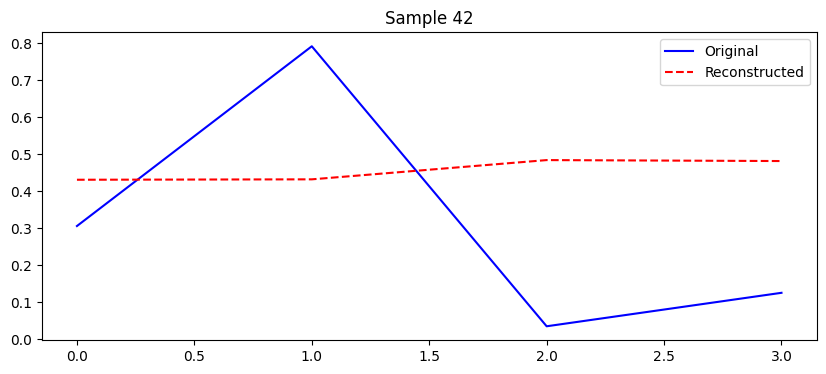

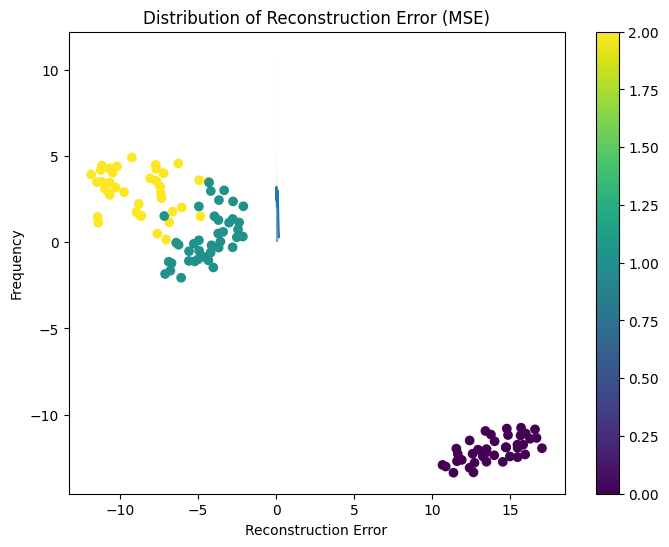

In [60]:
dataset_name = "iris"
model_path = 'iris/LogisticRegression'
output_path = '../../../results/iris_ssnp'

dice_cf = DiceCounterfactual(
        dataset_name=dataset_name,
        data_columns=iris.data.feature_names,
        model_name=model_path,
        outcome_name="target",
        preprocessing=None,
        backend="TF2",
        model_format="h5",
        multi_class=True,
        comparison=False
    )

output_path_train_test = os.path.join(output_path)

dice_cf.evaluate_autoencoder(save_path=output_path_train_test, version='MSE_test')

In [67]:
# Fit DiceCounterfactual
counterfactuals, dataset, predictions_dataset, intermediate_y_pred, _, cf_points_binary, _, _, intermediate_points, _, _, _, _, _, _, _ = dice_cf.fit_transform_all_gradient(
    num_samples=X_train.shape[0], total_cfs=1, desired_class="opposite", learning_rate=0.01
)                                                                
#Save the results

dice_cf.save_data(path=output_path_train_test, version=f'MSE_test_ssnp')

_, model_for_predictions = load_model_dice('TF2', f'{model_path}')

predictions_dataset_output = [np.argmax(x) for x in predictions_dataset]
intermediate_y_pred_output = [np.argmax(x) for x in intermediate_y_pred]

4/4 [==============================] - 0s 14ms/step
Sampled indices: [ 42  70  92  30  47  29  83  58  50  27   3  16  93  49  85  71  15 117
  45 119   0 115  89  99 114  21  63  33  72 110  60 116  44  80  54  23
  19 104  40  48   5  69  36  26  25  52  43  22 102   7  37  34 107  75
  14  39  32  38  35  64  81  20  51  88   9  12  95  67  68  86  41  91
 106  76  24  56  65  78  55   8  84  59 109  96  61  73  62  90  28 108
  77   2  87  66  53  57  13  46 101  94  97  98  17  31 103 111 100  10
  82 118 105  11  79   6   1  74   4 113 112  18]
Processing #0 instance 42... with prediction [0.49863538 0.27295095 0.22841363]
Generating counterfactuals for current class 0 and target class 1...
Generation of counterfactuals started...
Initial prediction for query instance: [0.39044502 0.31156337 0.29799163]
Target class defined: 1
step 1,  loss=1.16623
step 51,  loss=0.97581
step 101,  loss=0.8807
Stopping optimization because loss has converged.
Diverse Counterfactuals found! total 

4/4 [==============================] - 0s 6ms/step
Original data projected to 2D.
633/633 [==============================] - 1s 1ms/step
Grid created.
Plot saved as ../../../results/iris_ssnp\MSE_test_ssnp_predicted_points.png.
Plot saved as ../../../results/iris_ssnp\MSE_test_ssnp_predicted_points.png.
self.combined_hd_data (20613, 4)
Constructing KDTree in SSNP space with combined data...
KDTree constructed.
4/4 [==============================] - 0s 2ms/step
Processed 0 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 1000 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 2000 / 90000 grid points.
4/4 [==============================] - 0s 3ms/step
Processed 3000 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 4000 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 5000 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 6000 /

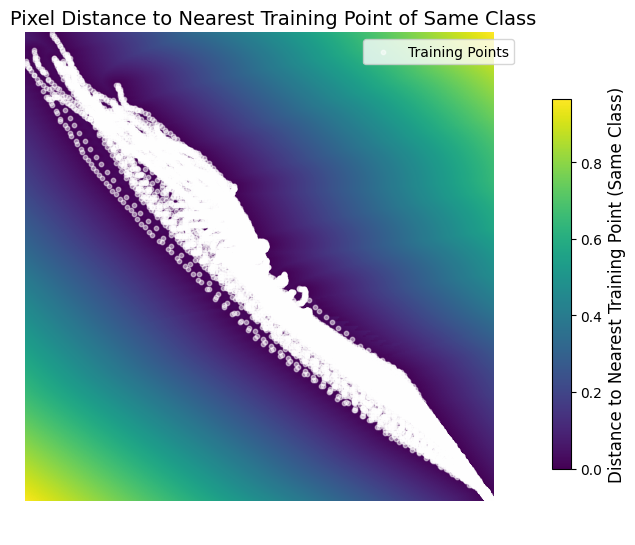

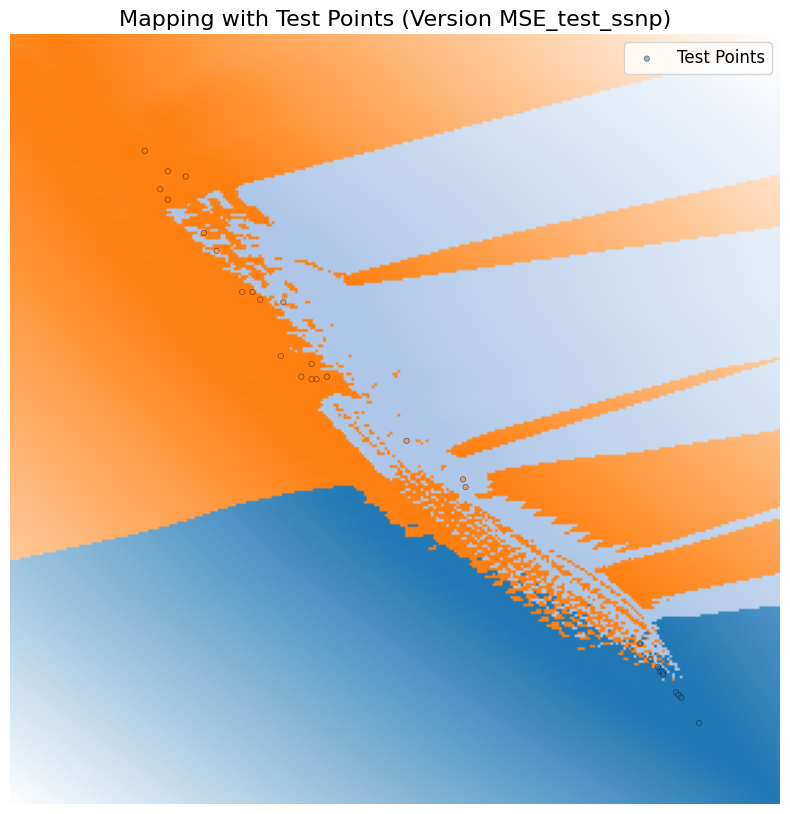

In [68]:
pred_map = create_map_embedding.PredictionMap(grid_size=300, 
                                                original_data=dataset, 
                                                intermediate_gradient_points=intermediate_points, 
                                                counterfactuals=counterfactuals,  
                                                number_of_neighbors=3, 
                                                model_for_predictions=model_for_predictions, 
                                                projection_method='ssnp',
                                                intermediate_predictions=np.array(intermediate_y_pred_output), 
                                                original_predictions=np.array(predictions_dataset_output), 
                                                counterfactual_predictions=np.array(cf_points_binary), 
                                                outcome_name='target', 
                                                n_classes=3, 
                                                version='MSE_test_ssnp', 
                                                comparison=False)
    
    
pred_map.fit_points_2D(path=output_path_train_test)

pred_map.fit_grid_multilateration(path=output_path_train_test)

pred_map.plot_test_points_on_mapping(X_test, path=output_path_train_test)

pred_map.plot_data_with_predictions(X_test=X_test, path=output_path_train_test)

In [1]:
import json

with open('../../../results/iris_ssnp/MSE_results_ssnp.json', 'r') as file:
    MSE_results = json.load(file)

In [4]:
mean_mses = [value['mse_mean'] for value in MSE_results.values()]
overall_mean_mse = np.mean(mean_mses)
print(overall_mean_mse)

0.012988828957273211


In [10]:
import json
import os
import numpy as np

input_dir = '../../../experiment_output/lamp/fashionmnist_hidden_layer'
for tt in ["1", "2", "3"]:
    open_path = os.path.join(input_dir, f'train_test_{tt}', 'MSE_results_ssnp.json')
    with open(open_path, 'r') as file:
        MSE_results = json.load(file)

    mean_mses = [value['mse_mean'] for value in MSE_results.values()]
    overall_mean_mse = np.mean(mean_mses)
    print('overall mean mse:', overall_mean_mse, 'for train_test:', tt)

overall mean mse: 0.017128624009140992 for train_test: 1


FileNotFoundError: [Errno 2] No such file or directory: '../../../experiment_output/lamp/fashionmnist_hidden_layer\\train_test_2\\MSE_results_ssnp.json'